**Loan Approval System**
We'll build a LangGraph workflow that:

Gathers applicant data
Calculates a credit score
Decides based on multiple thresholds:
🟢 Approve loan
🟡 Refer to manual review
🔴 Reject loan
Each condition leads to a different downstream path with more logic.

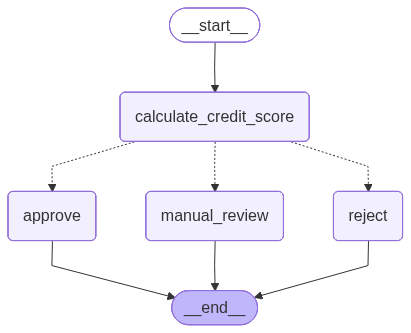

In [13]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
import matplotlib.pyplot as plt
from IPython.display import Image, display

class LoanStatus(TypedDict):
    name: str
    age: int
    income: int
    loan_amount: float
    credit_score: float
    decision: str
    remarks: str

def calculate_credit_score(state: LoanStatus) -> LoanStatus:
    # Simple credit score calculation based on income and loan amount
    if state['income'] <= 0 or state['loan_amount'] <= 0:
        score = 0.0
    else:
        score = (state['income'] / state['loan_amount']) * 100
        score = min(score, 850.0)
    return {'credit_score': score}

def evaluate_credit_score(state: LoanStatus) -> Literal['approve', 'manual_review', 'reject']:
    score = state['credit_score']
    if score >= 250:
        return 'approve'
    elif 150 <= score < 250:
        return 'manual_review'
    else:
        return 'reject'

def approve_loan(state: LoanStatus) -> LoanStatus:
    return {
        'decision': 'Approved ✅',
        'remarks': f"Loan approved for {state['name']}"
    }

def manual_review(state: LoanStatus) -> LoanStatus:
    remarks = f"Loan referred for manual review for {state['name']}."
    return {"decision": "Pending Manual Review 🕵️‍♂️", "remarks": remarks}

def reject_loan(state: LoanStatus) -> LoanStatus:
    return {
        "decision": "Rejected ❌",
        "remarks": f"Loan rejected for {state['name']} due to low credit score ({state['credit_score']:.2f})"
    }

# Create the graph
graph = StateGraph(LoanStatus)

# Add nodes
graph.add_node("calculate_credit_score", calculate_credit_score)
graph.add_node("approve", approve_loan)
graph.add_node("manual_review", manual_review)
graph.add_node("reject", reject_loan)

# Define the flow
graph.add_edge(START, "calculate_credit_score")

# Connect calculate_credit_score to decision nodes based on condition
graph.add_conditional_edges(
    "calculate_credit_score", 
    evaluate_credit_score,
    {
        'approve': 'approve',
        'manual_review': 'manual_review',
        'reject': 'reject'
    }
)

# Connect all decision nodes to END
graph.add_edge("approve", END)
graph.add_edge("manual_review", END)
graph.add_edge("reject", END)

# Compile
workflow = graph.compile()

# Visualize the graph
try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except:
    # If visualization fails, print the graph structure
    print("Graph Structure:")
    print("START -> calculate_credit_score")
    print("calculate_credit_score -> (conditional)")
    print("  ├─ if score >= 250 -> approve -> END")
    print("  ├─ if 150 <= score < 250 -> manual_review -> END")
    print("  └─ if score < 150 -> reject -> END")


In [14]:
test_cases = [
    {
        'name': 'High Score',
        'age': 35,
        'income': 100000,
        'loan_amount': 200000,  # income/loan_amount = 0.5 * 100 = 50 -> score=50
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    },
    {
        'name': 'Medium Score',
        'age': 40,
        'income': 80000,
        'loan_amount': 400000,  # income/loan_amount = 0.2 * 100 = 20 -> score=20
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    },
    {
        'name': 'Low Score',
        'age': 25,
        'income': 30000,
        'loan_amount': 500000,  # income/loan_amount = 0.06 * 100 = 6 -> score=6
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    }
]

print("\n" + "="*50)
print("Testing Loan Approval System")
print("="*50)

for test in test_cases:
    print(f"\nApplicant: {test['name']}")
    print(f"Income: ${test['income']:,}")
    print(f"Loan Amount: ${test['loan_amount']:,}")
    
    result = workflow.invoke(test)
    
    print(f"Credit Score: {result['credit_score']:.2f}")
    print(f"Decision: {result['decision']}")
    print(f"Remarks: {result['remarks']}")
    print("-" * 30)


Testing Loan Approval System

Applicant: High Score
Income: $100,000
Loan Amount: $200,000
Credit Score: 50.00
Decision: Rejected ❌
Remarks: Loan rejected for High Score due to low credit score (50.00)
------------------------------

Applicant: Medium Score
Income: $80,000
Loan Amount: $400,000
Credit Score: 20.00
Decision: Rejected ❌
Remarks: Loan rejected for Medium Score due to low credit score (20.00)
------------------------------

Applicant: Low Score
Income: $30,000
Loan Amount: $500,000
Credit Score: 6.00
Decision: Rejected ❌
Remarks: Loan rejected for Low Score due to low credit score (6.00)
------------------------------


LLM Based conditional review Handling

In [15]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

/home/lang-chain/miniconda3/envs/Agentic_AI_MCP_RAG_Chat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [16]:
model = ChatGroq(
    model = "llama-3.1-8b-instant",
    temperature=0.7,
    max_tokens=100
)

In [20]:
class SentimentSchema(BaseModel):
    sentiment:Literal['positive','negative'] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX","Performance","Bug","Support","Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")


structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [21]:
#quick test
prompt = "What is the sentiment of the following review - The software is buggy"
print(structured_model.invoke(prompt).sentiment)

negative


In [22]:
class ReviewState(TypedDict):
    review:str
    sentiment: Literal['Positive','Negative']
    diagnosis:dict
    response: str

#get the sentiment of the review
def find_sentiment(state:ReviewState):
    prompt = f"For the following review find out the sentiment:\n{state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment':sentiment}

#conditional
def check_sentiment(state:ReviewState)->Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'].lower() == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

#positive response
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
                \n\n\"{state['review']}\"\n
                Also, kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return {'response': response}

#run diagnosis
def run_diagnosis(state: ReviewState):
    prompt = f""" Diagnose this review \n\n{state['review']}\n
    return issue_type,tone, and urgency.
    """
    response = structured_model2.invoke(prompt)
    return {'diagnosis': response.model_dump()}


#negative response
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
                The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
                Write an empathetic, helpful resolution message. """
    response = model.invoke(prompt).content
    return {'response':response}


    


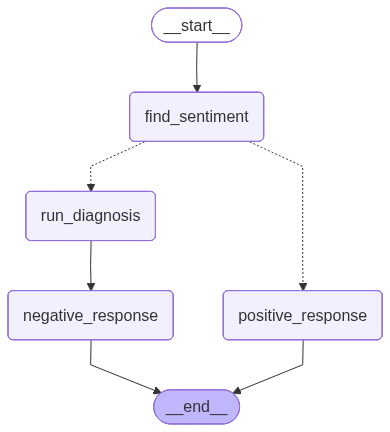

In [23]:
graph = StateGraph(ReviewState)

# Add Nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

# Define Edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

# Compile the workflow
workflow = graph.compile()
workflow

In [24]:
initial_state = {
    'review': "The new update is amazing! Everything feels faster and more intuitive. Great job by the dev team — really impressed!"
}
workflow.invoke(initial_state)

{'review': 'The new update is amazing! Everything feels faster and more intuitive. Great job by the dev team — really impressed!',
 'sentiment': 'positive',
 'response': '"Thank you so much for your kind words about our latest update! We\'re thrilled to hear that you\'re experiencing a faster and more intuitive experience. Our development team works hard to bring you the best possible product, and it\'s feedback like yours that motivates us to keep pushing the boundaries of what\'s possible.\n\nIf you have a few minutes, we\'d love for you to share your thoughts with the rest of our community on our website. Your feedback will help us continue to improve and make our'}

In [25]:
initial_state = {
    'review': "The checkout process is painfully slow and keeps throwing errors. I’ve had to restart multiple times, and it’s really frustrating. This needs to be fixed ASAP."
}

workflow.invoke(initial_state)

{'review': 'The checkout process is painfully slow and keeps throwing errors. I’ve had to restart multiple times, and it’s really frustrating. This needs to be fixed ASAP.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': "Subject: Re: Performance Issue - Resolved\n\nDear [User],\n\nI understand that you're experiencing a 'Performance' issue and I'm so sorry to hear that it's impacting your workflow. I can imagine how frustrating this must be for you.\n\nI want to assure you that I've taken immediate action to investigate and resolve the issue. Our team has worked diligently to identify the root cause, and I'm pleased to inform you that the problem has been fixed.\n\nTo confirm, I've performed the"}